In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
import gensim
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
import re
import string
import math
from collections import defaultdict
import random
import warnings
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc,plot_roc_curve,accuracy_score,auc,accuracy_score,f1_score

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig,TrainingArguments,Trainer
from datasets import Dataset,DatasetDict
import torch.nn.utils.prune as prune
import wandb
import optuna
from optimum.onnxruntime import ORTConfig, ORTQuantizer
from prettytable import PrettyTable
import copy


warnings.filterwarnings("ignore", message="No positive samples in y_true, true positive value should be meaningless")
warnings.filterwarnings("ignore", message="No negative samples in y_true, false positive value should be meaningless")



In [2]:
# Setting a random seed so we can compare the models
random.seed(0)

In [4]:
## Activating cuda

!Conda activate tf_GPU

In [5]:
## Checking if cuda is available

torch.cuda.is_available()

True

In [6]:
## Getting the torch device name

torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [3]:
## Defining the models we are going to use

model_name_XLNet='xlnet-base-cased'
model_name_Roberta='roberta-base'

# Defining Class Settings

In [4]:
class PreTrainedModel():
    
    # Initializing the model's attributes
    
    def __init__(self,model_name,lr,loss_func,dataset):
        self.model_name=model_name
        self.lr=lr
        self.model=AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=2,return_dict=True)
        self.optimizer=torch.optim.Adam(self.model.parameters(), self.lr)
        self.loss_func = loss_func
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.dataset=dataset
        self.tokenized_dataset=None
    
    # A function to tokenize reviews
    
    def tokenize(self,parameters):
        self.tokenized_dataset=self.dataset.map(self.tokenizer, input_columns='text', fn_kwargs=parameters)
        for split in self.tokenized_dataset:
                self.tokenized_dataset[split] = self.tokenized_dataset[split].add_column('labels',self.dataset[split]['labels'])
                self.tokenized_dataset[split]=self.tokenized_dataset[split].remove_columns(['text'])
        self.tokenized_dataset.set_format('torch')
        return
    
    # A function to evaluate accuracy and F1 metrics
    
    def metric_fn(self,predictions):
        preds = predictions.predictions.argmax(axis=1)
        labels = predictions.label_ids
        return {'f1': f1_score(labels, preds, average='binary')
               ,'accuracy':accuracy_score(labels,preds)}
    
    # A function to train the model
    
    def train(self,train_args):
        trainer = Trainer(
            model=self.model,
            args=train_args,
            train_dataset=self.tokenized_dataset['train'],
            eval_dataset=self.tokenized_dataset['test'],
            compute_metrics=self.metric_fn)
        
        trainer.train()
    
    # A function to return the model init attribute
    
    def model_init(self):
        return self.model
    
    # A function to perform a hyperparameter random search using XLNet
    
    def hpm_search_XLNet(self,train_args):
        wandb.init(entity="group2tau")
        %env WANDB_PROJECT=XLNet
        trainer = Trainer(
            model=self.model,
            args=train_args,
            train_dataset=self.tokenized_dataset['train'],
            eval_dataset=self.tokenized_dataset['test'],
            model_init=self.model_init,
            compute_metrics=self.metric_fn)
        
        trainer.hyperparameter_search(direction="maximize", hp_space=self.my_hp_space,n_trials=20)
    
    # A function to perform a hyperparameter random search using XLNet
    
    def hpm_search_Roberta(self,train_args):
        wandb.init(entity="group2tau")
        %env WANDB_PROJECT=Roberta
        trainer = Trainer(
            model=self.model,
            args=train_args,
            train_dataset=self.tokenized_dataset['train'],
            eval_dataset=self.tokenized_dataset['test'],
            model_init=self.model_init,
            compute_metrics=self.metric_fn)
        
        trainer.hyperparameter_search(direction="maximize", hp_space=self.my_hp_space,n_trials=20)
    
    # A function that returns the hyperparameter search space arguments
    
    def my_hp_space(self,trial):
        return {"learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
                "num_train_epochs": trial.suggest_int("num_train_epochs", 3,3),
                "seed": trial.suggest_int("seed", 0, 0),
                "per_device_train_batch_size": trial.suggest_int("per_device_train_batch_size", 16,27),
                "gradient_accumulation_steps":trial.suggest_int("gradient_accumulation_steps",1,6),
                "warmup_steps":trial.suggest_int("warmup_steps",0,500),
                "weight_decay":trial.suggest_float("weight_decay",1e-4,1e-2),
                "per_device_eval_batch_size":trial.suggest_int("per_device_eval_batch_size",16,16)}
    
    # A function to show the modules and parameters in the model
    
    def show_parameters(self):
        table = PrettyTable(["Modules", "Parameters","Sum of Tensor"])
        total_params = 0
        for name, parameter in self.model.named_parameters():
            if not parameter.requires_grad: 
                continue
            params = parameter.numel()
            total=float(str(parameter.sum()).split(',')[0][7:])
            table.add_row([name, params,total])
            total_params+=params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        return total_params
    
    # A function to prune the weights of the feed-forward layer in XLNet with a hyperparameter of the amount to prune
    
    def pruning(self,amount):
        for module,layer in list(self.model.named_modules()):
            if isinstance(layer,torch.nn.modules.linear.Linear) and 'ff' in module:
                print(f'\n{module}:\nold_total_weights = {layer.weight.sum()}')
                m=prune.l1_unstructured(layer,name="weight", amount=amount)
                m=prune.remove(m,name="weight")
                print(f'new_total_weights = {layer.weight.sum()}')
    
    # A function to quantize the weights of the feed-forward layer in XLNet with a hyperparameter of the scale
    
    def quantization(self,scale):
        for i,(module,layer) in enumerate(list(self.model.named_modules())):
            if isinstance(layer,torch.nn.modules.linear.Linear) and 'ff' in module:
                weights=torch.quantize_per_tensor(layer.weight, 0.1, 0, torch.quint8).int_repr()
                list(self.model.named_modules())[i][1].weight.data=weights

    # A function to print the model's size
    
    def print_model_size(self):
        torch.save(self.model.state_dict(), "tmp.pt")
        print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
        os.remove('tmp.pt')



# Reading the data

In [5]:
vocab_path='imdb.vocab'

def make_vocab(path):
    # Reading imdb vocab file
    with open(path,encoding="utf8") as file:
        words_list=file.readlines()
    
    # Splitting /n and "" from the words
    words_list=[s.split('\n')[0].split('""')[0] for s in words_list]
    # Generating a list of lists containing the vocab word
    words_list=[[word] for word in words_list]
    return words_list

# A list to hold the imdb vocab
words_list=make_vocab(vocab_path)

# Exploration and Pre-Processing

In [6]:
# Function to read the  imdb files

def read_files(path):
    """
    Run this script from the root directory
    """
    for file in glob.glob(f"{path}\*.txt"):
        yield file
        
# Function to clean a review query (lower case, special characters)     

def clean_query(query):
    for punc in string.punctuation:
        if punc == "'":
            query=query.replace(punc,'')
        else:
            query=query.replace(punc,' ')
    return lower(query.replace('br',' '))

# Function to load reviews

def load_reviews(path):
    reviews = {}
    for file_name in read_files(path):
        split=file_name.split('_')
        if len(split)==2:
            review_ind=int(split[0].split('\\')[-1])
            if review_ind not in reviews:
                with open(file_name, encoding='UTF-8') as file:
                    reviews[review_ind]=([clean_query(file.read())],int(split[1].split('.')[0]))
    return reviews

    
# Function to initiate loading of positive reviews

def load_positive_reviews():
    path = "train/pos"
    return load_reviews(path)

# Function to initiate loading of negative reviews

def load_negative_reviews():
    path = "train/neg"
    return load_reviews(path)
    
# Function that creates a word counter in all of the reviews and deletes word with less than 5 appearances

def create_word_counter(reviews):
    reviews_list =reviews
    word_counter = {}
    for review in reviews_list.values():
        review_text = review[0][0]
        for word in review_text.split():
            if word.lower() in word_counter:
                word_counter[word.lower()] +=1
            else:
                word_counter[word.lower()] =1
                
    # Remove words with less than 5 appearances
    
    words_to_remove = set()
    clean_word_counter = {}
    for word, count in word_counter.items():
        if count < 5: 
            words_to_remove.add(word)
        else:
            clean_word_counter[word] = count

    for review in reviews_list.keys(): 
        review_text = reviews_list[review][0][0]
        text_without_uncommon_words = []
        for word in review_text.split():
            if word not in words_to_remove:
                text_without_uncommon_words.append(word)
        reviews_list[review]=([" ".join(text_without_uncommon_words)],reviews_list[review][1])

        
    return clean_word_counter, reviews_list

### Function that creates a word counter of the top K words that appear
### both in the positive and the negative reviews and deletes them from all reviews 

def top_k_word_counter(all_reviews, k):
    word_counter = {}
    for r in all_reviews:
        reviews_list = r
        for review in reviews_list.values():
            review_text = review[0][0]
            for word in review_text.split():
                if word.lower() in word_counter:
                    word_counter[word.lower()] +=1
                else:
                    word_counter[word.lower()] =1
    return dict(sorted([(k,v) for k,v in word_counter.items()], key=lambda x: x[1], reverse=True)[:k])

def get_word_probs(all_reviews) -> dict:
    """
    Count the number of words in all the documents
    :return: dictionary of word: probability
    """
    log_factor_to_divide = 30
    word_counter = defaultdict(int)
    for r in all_reviews:
        reviews_list = r
        for review in reviews_list.values():
            review_text = review[0][0]
            for word in review_text.split():
                word_counter[word.lower()] += 1
    word_to_prob = sorted([[k,v] for k,v in word_counter.items()], key= lambda x: x[1], reverse=True)
    
    return dict(word_to_prob)

def delete_words_by(all_reviews, min_count=5, top_k=0, probs=False):
    """
    Delete words by critiria
    You can delete by min count of words (default 5 words)
    You can delete by top K of most common words
    You can delete from certain probabaiities of word occurence

    :param all_reviews: list of reviws dictionary
    :param min_count: min count of word count in reviews defaults to 5
    :param top_k: top K most comon words to delete, defaults to 0
    :param probs: delete by word probabilities, defaults to False
    :return: reviews dictionary
    """
    word_counter = {}
    for r in all_reviews:
        reviews_list = r
        for review in reviews_list.values():
            review_text = review[0][0]
            for word in review_text.split():
                if word.lower() in word_counter:
                    word_counter[word.lower()] +=1
    
    words_to_remove = set() # Set of words to remove by criteria
    if top_k > 0:
        words = top_k_word_counter(all_reviews, top_k) # get top k words
        for w in words.keys():
            words_to_remove.add(w) # add top K words to the set of words we will remove


    if min_count > 0: 
        for word, count in word_counter.items():
            if count < min_count: 
                words_to_remove.add(word)
    if probs:
        word_probs = get_word_probs(all_reviews)  
    
    all_reviews_to_return={}
    count=0
    for reviews_dict in all_reviews:
        num_of_reviews=len(reviews_dict.keys())
        for review in reviews_dict.keys(): 
            review_text = reviews_dict[review][0][0]
            text_without_uncommon_words = []
            for word in review_text.split():
                if word not in words_to_remove:
                    if probs:
                        word_deletion_chance = np.random.uniform(0,1)
                        if word_deletion_chance < word_probs[word.lower()]: # Add the word only if it's not deleted
                            text_without_uncommon_words.append(word)
                    
                    else:
                        text_without_uncommon_words.append(word)
            all_reviews_to_return[review+count]=([" ".join(text_without_uncommon_words)],reviews_dict[review][1])
        count+=num_of_reviews
    return all_reviews_to_return
    

# Function to transform the reviews to lower case

def lower(query):
    return " ".join(list(map(lambda x:x.lower(),query.split())))

# Function to concatenate all reviews into one list

def concatsentences(lst,query):
    lst.append(lower(query[0]).split())
    return


def sort_dict(x: dict, reverse=True) -> dict:
    """
    Sort a dictionary to display it on a graph

    :param x: dictionary with some values
    :return: sorted dictionary
    """
    return {k:v for k,v in sorted(x.items(), key=lambda i: i[1], reverse=reverse)}


## Exploration 
We'll explore the data by showing statistics, data types, and Number of unique words, distribution

In addition, we'll plot some visualization to better understend the data

In [7]:
def plot_common_words(hist: dict, title, n=20) -> None:
    """
    Plot common word histogram
    :param hist: dictionary with data to plot
    """
    _, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(title)
    ax.set_ylabel('Number of appearances')
    ax.set_xlabel('Word')
    ax.set_xticklabels(labels=list(hist.keys())[:n] ,rotation = 90)
    ax.bar(list(hist.keys())[:n], list(hist.values())[:n])
    plt.show()


C:\Users\gal73\AppData\Local\Temp\ipykernel_22112\1397745345.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(hist.keys())[:n] ,rotation = 90)


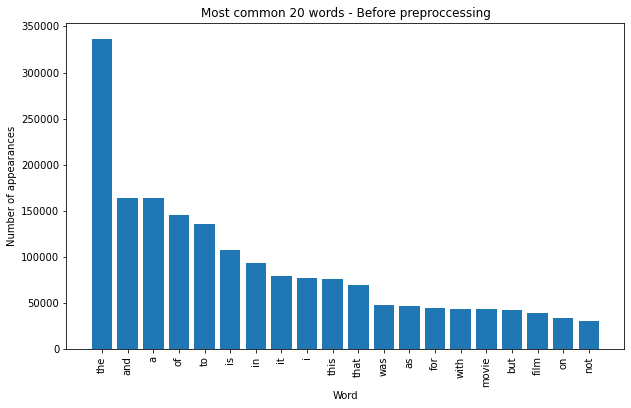

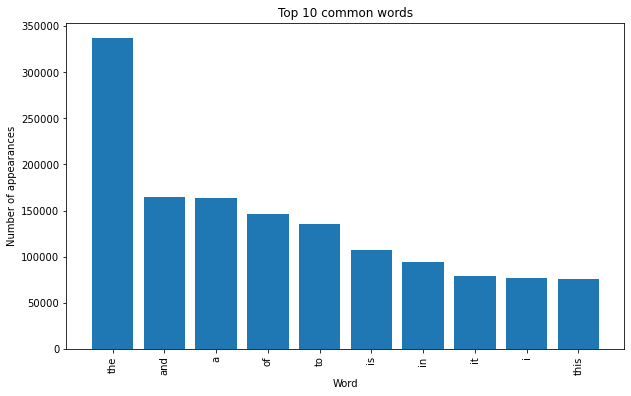

In [8]:
revs = [load_positive_reviews(), load_negative_reviews()] # which reviews you want to take care of - pos, neg or both

all_words_preprocess = delete_words_by(revs)


# Plotting Top Common Words before dropping common words

plot_common_words(sort_dict(create_word_counter(all_words_preprocess)[0]),'Most common 20 words - Before preproccessing')
plot_common_words(sort_dict(create_word_counter(all_words_preprocess)[0]),'Top 10 common words',10)

In [9]:
## Calculating the average review length and average review rating before cleaning the reviews

all_reviews_uncleaned=delete_words_by(revs, 0, 0, False)

num_of_reviews=0
len_of_reviews=0
rating=0

for key,value in all_reviews_uncleaned.items():
    len_of_reviews+=len(value[0][0])
    rating+=value[1]
    num_of_reviews+=1

avg_review_length_cleaned=round(len_of_reviews/num_of_reviews,0)
avg_review_rating=round(rating/num_of_reviews,2)

print(f"Average review length before pre-processing is : {avg_review_length_cleaned}\n")
print(f"Average review rating is : {avg_review_rating}")

Average review length before pre-processing is : 1263.0

Average review rating is : 5.48


C:\Users\gal73\AppData\Local\Temp\ipykernel_22112\1397745345.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(hist.keys())[:n] ,rotation = 90)


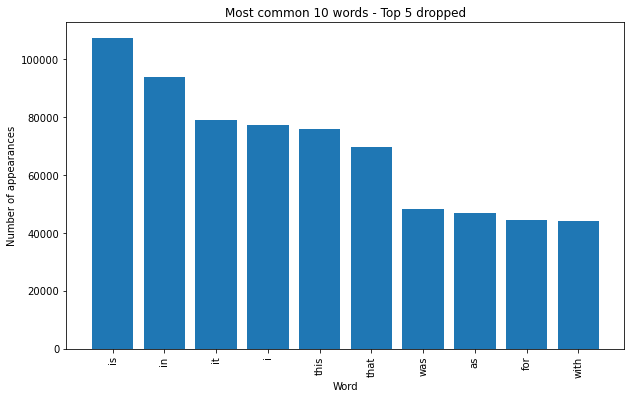

In [10]:
# Dropping top 5 common words

all_words_top_k_dropped = delete_words_by(revs,min_count=10,top_k=5)
plot_common_words(sort_dict(create_word_counter(all_words_top_k_dropped)[0]),'Most common 10 words - Top 5 dropped',10)

C:\Users\gal73\AppData\Local\Temp\ipykernel_22112\1397745345.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(hist.keys())[:n] ,rotation = 90)


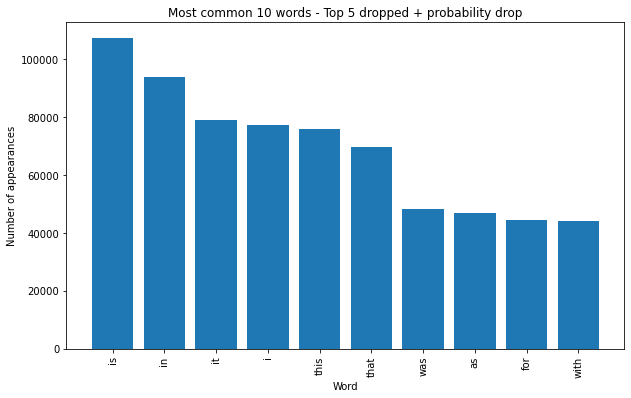

In [11]:


all_reviews_cleaned=delete_words_by(revs, 10, 5, True)
clean_counter= sort_dict(create_word_counter(all_reviews_cleaned)[0])

# After dropping top 5 common words + probability drop

plot_common_words(clean_counter, 'Most common 10 words - Top 5 dropped + probability drop',10)

In [12]:
## Calculating the average review length after cleaning the reviews

num_of_reviews=0
len_of_reviews=0

for key,value in all_reviews_cleaned.items():
    len_of_reviews+=len(value[0][0])
    rating+=value[1]
    num_of_reviews+=1

avg_review_length_cleaned=round(len_of_reviews/num_of_reviews,0)

print(f"Average review length after pre-processing is : {avg_review_length_cleaned}")

Average review length after pre-processing is : 1107.0


## Pre-Processing

In [11]:
# Loading all reviews into positive and negative lists

sentences=[]
revs = [load_positive_reviews(),load_negative_reviews()] # which reviews you want to take care of - pos, neg or both


all_reviews_cleaned=delete_words_by(revs, 10, 5, True)


# Splitting the unified reviews into negative and positive by the rating (higher or lower than 5)

pos_reviews={}
neg_reviews={}
num_of_reviews=int(len(all_reviews_cleaned)/2)
for key,value in all_reviews_cleaned.items():
    if value[1]>=5:
        pos_reviews[key]=value
    else:
        neg_reviews[key-num_of_reviews]=value


for query in pos_reviews.keys():
    concatsentences(sentences,pos_reviews[query][0])

for query in neg_reviews.keys():
    concatsentences(sentences,neg_reviews[query][0])



In [12]:
neg_reviews

{0: (['story man who has unnatural feelings for pig starts out with opening scene that is terrific example absurd comedy formal orchestra audience is turned into an insane violent mob by crazy chantings its singers unfortunately it stays absurd whole time with no general narrative eventually making it just too off putting even those from era should be turned off cryptic dialogue would make shakespeare seem easy third grader on technical level its better than you might think with some good cinematography by future great vilmos zsigmond future stars sally kirkland frederic forrest can be seen iefly'],
  3),
 10000: (['airport 77 starts as new luxury 747 plane is loaded up with valuable paintings such belonging rich businessman philip stevens james stewart who is flying them bunch vips his estate in preparation it being opened public as museum also on board is stevens daughter julie kathleen quinlan her son luxury jetliner takes off as planned but mid air plane is hi jacked by co pilot ch

In [13]:
sentences

[['bromwell',
  'high',
  'is',
  'cartoon',
  'comedy',
  'it',
  'ran',
  'at',
  'same',
  'time',
  'as',
  'some',
  'other',
  'programs',
  'about',
  'school',
  'life',
  'such',
  'as',
  'teachers',
  'my',
  '35',
  'years',
  'in',
  'teaching',
  'profession',
  'lead',
  'me',
  'believe',
  'that',
  'bromwell',
  'highs',
  'satire',
  'is',
  'much',
  'closer',
  'reality',
  'than',
  'is',
  'teachers',
  'scramble',
  'survive',
  'financially',
  'insightful',
  'students',
  'who',
  'can',
  'see',
  'right',
  'through',
  'their',
  'pathetic',
  'teachers',
  'pomp',
  'pettiness',
  'whole',
  'situation',
  'all',
  'remind',
  'me',
  'schools',
  'i',
  'knew',
  'their',
  'students',
  'when',
  'i',
  'saw',
  'episode',
  'in',
  'which',
  'student',
  'repeatedly',
  'tried',
  'burn',
  'down',
  'school',
  'i',
  'immediately',
  'recalled',
  'at',
  'high',
  'classic',
  'line',
  'inspector',
  'im',
  'here',
  'sack',
  'one',
  'your',
  

# Arranging the data

In [14]:
## Shuffling concatenated data to keep the order of the tagging

def shuffledata(x_lst,y_lst):
    z=list(zip(x_lst,y_lst))
    random.shuffle(z)
    x,y=zip(*z)
    return x,y

# A function to split the data into text sets and labels sets

def split_data(test_sz):
    # Loading positive and negative reviews
    x_pos=[pos_reviews[i][0] for i in range(len(pos_reviews.keys()))]
    y_pos=[1 for i in range(len(pos_reviews.keys()))]
    x_neg=[neg_reviews[i][0] for i in range(len(neg_reviews.keys()))]
    y_neg=[0 for i in range(len(neg_reviews.keys()))]


    ## Stratifying the train and test sets
    
    x_pos_train, x_pos_test, y_pos_train, y_pos_test = train_test_split(x_pos, y_pos, test_size=test_sz, random_state=42)
    x_neg_train, x_neg_test, y_neg_train, y_neg_test = train_test_split(x_neg, y_neg, test_size=test_sz, random_state=42)

    x_combined_train=x_pos_train+x_neg_train
    x_combined_test=x_pos_test+x_neg_test
    y_combined_train=y_pos_train+y_neg_train
    y_combined_test=y_pos_test+y_neg_test

    x_final_train,y_final_train=shuffledata(x_combined_train,y_combined_train)
    x_final_test,y_final_test=shuffledata(x_combined_test,y_combined_test)
    
    return x_final_train,y_final_train,x_final_test,y_final_test

# Splitting the data into train and validation sets (75% train, 25% validation)

x_final_train,y_final_train,x_final_test,y_final_test=split_data(test_sz=0.25)

In [15]:
# Saving the train and validation sets in dataframes (so we can use the Datasets object)

train_df=pd.DataFrame()
test_df=pd.DataFrame()

train_df['text']=[text[0] for text in x_final_train]
train_df['labels']=y_final_train

test_df['text']=[text[0] for text in x_final_test]
test_df['labels']=y_final_test



In [16]:
train_df

text  labels
0      well one has give director credit for how guts...       0
1      wow i just saw this on t v as one scary movies...       0
2      allison deans performance is what stands out i...       1
3      warning spoilers following superb recreation b...       0
4      name this film alone made me want see just wha...       1
...                                                  ...     ...
18745  i desperately want give this movie 10 i really...       0
18746  adam jones has illiant sense humor there is no...       1
18747  sure titanic was good movie first time you see...       1
18748  peeew this stinks as everyone knows its based ...       0
18749  my 7 year old daughter loved it as disney exec...       0

[18750 rows x 2 columns]

In [17]:
# Generating a datasets object so we can run the models using GPU (allows us to run on a batch size higher than 1)

train_ds=Dataset.from_pandas(train_df[:])
test_ds=Dataset.from_pandas(test_df[:])



dataset_united=DatasetDict({'train':train_ds,"test":test_ds})
dataset_united

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 18750
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 6250
    })
})

# Training Process

## Hyperparameter Random Search - XLNet

In [448]:
# Defining the loss function and loading the XLNet pretrained model so we can run a hyperparameter search

loss_func=torch.nn.BCELoss()

model1XLNet=PreTrainedModel(model_name_XLNet,1e-5,loss_func,dataset_united)

loading configuration file https://huggingface.co/xlnet-base-cased/resolve/main/config.json from cache at C:\Users\user/.cache\huggingface\transformers\06bdb0f5882dbb833618c81c3b4c996a0c79422fa2c95ffea3827f92fc2dba6b.da982e2e596ec73828dbae86525a1870e513bd63aae5a2dc773ccc840ac5c346
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation"

In [23]:
# Tokenizing the words in the reviews using XLNet loaded model

model1XLNet.tokenize({"max_length": 200, "truncation": True, "padding": "max_length"})

  0%|          | 0/18750 [00:00<?, ?ex/s]

  0%|          | 0/6250 [00:00<?, ?ex/s]

In [24]:
# Defining saving path, and initializing training arguments for hyperparameter search of XLNet and RoBerta

OUT_PATH=r"C:\Users\user\Desktop\Group2"

args = TrainingArguments(output_dir=OUT_PATH,
                         overwrite_output_dir=True,
                         save_strategy='no',
                         greater_is_better=True,
                         evaluation_strategy='epoch',
                         do_train=True,
                         logging_strategy='epoch',
                         report_to='wandb')

In [25]:
### Running a hyperparameter search on XLNet

model1XLNet.hpm_search_XLNet(args)

wandb: Currently logged in as: galzivoni (group2tau). Use `wandb login --relogin` to force relogin


C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\trainer.py:330: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  warnings.warn(
[I 2022-06-21 20:02:28,247] A new study created in memory with name: no-name-f45c2abd-d9f9-40ea-905d-2616fdd8f986


env: WANDB_PROJECT=XLNet


Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 72
  Gradient Accumulation steps = 3
  Total optimization steps = 2343


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-21 20:18:24,793] Trial 0 finished with value: 1.8488147226675218 and parameters: {'learning_rate': 2.206580980300754e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 24, 'gradient_accumulation_steps': 3, 'warmup_steps': 74, 'weight_decay': 0.004528550440472844, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.war

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-21 20:33:58,820] Trial 1 finished with value: 1.8404075135307227 and parameters: {'learning_rate': 1.7276458824432382e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 17, 'gradient_accumulation_steps': 6, 'warmup_steps': 483, 'weight_decay': 0.00044033735571658104, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-21 20:49:46,969] Trial 2 finished with value: 1.8390013510485033 and parameters: {'learning_rate': 2.5914500149240243e-06, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 22, 'gradient_accumulation_steps': 4, 'warmup_steps': 329, 'weight_decay': 0.0013987924607861467, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-21 21:05:33,497] Trial 3 finished with value: 1.8385934557063048 and parameters: {'learning_rate': 2.8711892325201892e-06, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 26, 'gradient_accumulation_steps': 5, 'warmup_steps': 153, 'weight_decay': 0.0032290504001957756, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-21 21:21:17,750] Trial 4 finished with value: 1.8334318661193558 and parameters: {'learning_rate': 2.6785683969814547e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 17, 'gradient_accumulation_steps': 6, 'warmup_steps': 426, 'weight_decay': 0.009080935014307564, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.w

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-21 21:37:16,880] Trial 5 finished with value: 1.8418400382836175 and parameters: {'learning_rate': 1.956209311345175e-06, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 25, 'gradient_accumulation_steps': 4, 'warmup_steps': 238, 'weight_decay': 0.007963879147762845, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.wa

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-21 21:49:15,866] Trial 6 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 27
  Total train batch size (w. parallel, distributed & accumulation) = 108
  Gradient Accumulation steps = 4
  Total optimization steps = 1758


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-21 22:00:01,638] Trial 7 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 19
  Total train batch size (w. parallel, distributed & accumulation) = 76
  Gradient Accumulation steps = 4
  Total optimization steps = 1758


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-21 22:10:54,378] Trial 8 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 40
  Gradient Accumulation steps = 2
  Total optimization steps = 3516


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-21 22:16:42,780] Trial 9 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 23
  Total train batch size (w. parallel, distributed & accumulation) = 46
  Gradient Accumulation steps = 2
  Total optimization steps = 3516


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-21 22:22:30,834] Trial 10 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 72
  Gradient Accumulation steps = 3
  Total optimization steps = 2343


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-21 22:39:12,266] Trial 11 finished with value: 1.8397436942675158 and parameters: {'learning_rate': 1.4654223372345515e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 24, 'gradient_accumulation_steps': 3, 'warmup_steps': 78, 'weight_decay': 0.005687414728706774, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.w

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-21 22:55:41,606] Trial 12 finished with value: 1.8391300367588301 and parameters: {'learning_rate': 1.1037871331504455e-06, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 24, 'gradient_accumulation_steps': 3, 'warmup_steps': 201, 'weight_decay': 0.007635950361923335, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-21 23:11:56,561] Trial 13 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 27
  Total train batch size (w. parallel, distributed & accumulation) = 54
  Gradient Accumulation steps = 2
  Total optimization steps = 3516


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-21 23:28:59,230] Trial 14 finished with value: 1.8369903579347482 and parameters: {'learning_rate': 3.50665295666079e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 27, 'gradient_accumulation_steps': 2, 'warmup_steps': 337, 'weight_decay': 0.004567169691670598, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.wa

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-21 23:45:50,727] Trial 15 finished with value: 1.8422819267822736 and parameters: {'learning_rate': 1.0499465590388638e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 22, 'gradient_accumulation_steps': 3, 'warmup_steps': 16, 'weight_decay': 0.008268848858671206, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.w

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-22 00:04:32,151] Trial 16 finished with value: 1.8399993574297189 and parameters: {'learning_rate': 9.83204675260792e-06, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 22, 'gradient_accumulation_steps': 1, 'warmup_steps': 9, 'weight_decay': 0.005036974100376804, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-22 00:21:16,636] Trial 17 finished with value: 1.8413329908492533 and parameters: {'learning_rate': 2.075044923392281e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 20, 'gradient_accumulation_steps': 3, 'warmup_steps': 80, 'weight_decay': 0.009951174823506536, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.wa

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-22 00:38:36,827] Trial 18 finished with value: 1.8413584978334137 and parameters: {'learning_rate': 1.078941258778072e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 23, 'gradient_accumulation_steps': 2, 'warmup_steps': 67, 'weight_decay': 0.0021921982230167104, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.w

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-22 00:55:26,338] Trial 19 finished with value: 1.841050783055199 and parameters: {'learning_rate': 4.652946000760824e-06, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 21, 'gradient_accumulation_steps': 3, 'warmup_steps': 143, 'weight_decay': 0.006465707161108676, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8488147226675218.


## Hyperparameter Random Search - RoBERTa

In [27]:
# Loading the Roberta pretrained model so we can run a hyperparameter search

model2Roberta=PreTrainedModel(model_name_Roberta,1e-5,loss_func,dataset_united)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at C:\Users\user/.cache\huggingface\transformers\733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/robert

In [28]:
# Tokenizing the words in the reviews using RoBerta loaded model

model2Roberta.tokenize({"max_length": 200, "truncation": True, "padding": "max_length"})

  0%|          | 0/18750 [00:00<?, ?ex/s]

  0%|          | 0/6250 [00:00<?, ?ex/s]

In [29]:
### Running a hyperparameter search on RoBerta

model2Roberta.hpm_search_Roberta(args)

C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\trainer.py:330: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  warnings.warn(
[I 2022-06-22 00:56:36,322] A new study created in memory with name: no-name-ee5fe567-966c-4bf8-966b-43847c36734c
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 19
  Total train batch size (w. parallel, distributed & accumulation) = 19
  Gradient Accumulation steps = 1
  Total optimization steps = 

env: WANDB_PROJECT=Roberta


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-22 01:05:14,965] Trial 0 finished with value: 1.8378507527569123 and parameters: {'learning_rate': 1.7262328040551758e-06, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 19, 'gradient_accumulation_steps': 1, 'warmup_steps': 161, 'weight_decay': 0.008442612778004416, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 1.8378507527569123.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.w

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-22 01:13:15,130] Trial 1 finished with value: 1.859888919306064 and parameters: {'learning_rate': 1.6925054012927097e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 4, 'warmup_steps': 325, 'weight_decay': 0.008615071033690143, 'per_device_eval_batch_size': 16}. Best is trial 1 with value: 1.859888919306064.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.war

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-22 01:21:26,566] Trial 2 finished with value: 1.8605246178445793 and parameters: {'learning_rate': 3.3344209241941356e-06, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 19, 'gradient_accumulation_steps': 3, 'warmup_steps': 263, 'weight_decay': 0.00965445883208908, 'per_device_eval_batch_size': 16}. Best is trial 2 with value: 1.8605246178445793.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.wa

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-22 01:29:26,668] Trial 3 finished with value: 1.859245027182603 and parameters: {'learning_rate': 2.727583312318525e-06, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 17, 'gradient_accumulation_steps': 5, 'warmup_steps': 74, 'weight_decay': 0.007878472503913695, 'per_device_eval_batch_size': 16}. Best is trial 2 with value: 1.8605246178445793.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-22 01:37:28,778] Trial 4 finished with value: 1.8556038228290204 and parameters: {'learning_rate': 2.829124619492341e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 27, 'gradient_accumulation_steps': 5, 'warmup_steps': 312, 'weight_decay': 0.009296389752587992, 'per_device_eval_batch_size': 16}. Best is trial 2 with value: 1.8605246178445793.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.wa

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 01:45:29,295] Trial 5 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 19
  Total train batch size (w. parallel, distributed & accumulation) = 114
  Gradient Accumulation steps = 6
  Total optimization steps = 444


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 01:53:31,228] Trial 6 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 80
  Gradient Accumulation steps = 5
  Total optimization steps = 534


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 02:01:37,161] Trial 7 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 22
  Total train batch size (w. parallel, distributed & accumulation) = 22
  Gradient Accumulation steps = 1
  Total optimization steps = 2679


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 02:10:25,622] Trial 8 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 80
  Gradient Accumulation steps = 4
  Total optimization steps = 669


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 02:18:39,056] Trial 9 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 25
  Total train batch size (w. parallel, distributed & accumulation) = 50
  Gradient Accumulation steps = 2
  Total optimization steps = 1338


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 02:27:06,255] Trial 10 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 17
  Total train batch size (w. parallel, distributed & accumulation) = 51
  Gradient Accumulation steps = 3
  Total optimization steps = 891


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 02:35:22,786] Trial 11 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 18
  Total train batch size (w. parallel, distributed & accumulation) = 54
  Gradient Accumulation steps = 3
  Total optimization steps = 891


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2022-06-22 02:44:10,206] Trial 12 finished with value: 1.8594637630104085 and parameters: {'learning_rate': 1.4056189745819482e-05, 'num_train_epochs': 3, 'seed': 0, 'per_device_train_batch_size': 18, 'gradient_accumulation_steps': 3, 'warmup_steps': 225, 'weight_decay': 0.007068534926535169, 'per_device_eval_batch_size': 16}. Best is trial 2 with value: 1.8605246178445793.
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 02:52:36,724] Trial 13 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1338


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 03:01:05,772] Trial 14 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 18
  Total train batch size (w. parallel, distributed & accumulation) = 54
  Gradient Accumulation steps = 3
  Total optimization steps = 891


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 03:10:14,644] Trial 15 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 80
  Gradient Accumulation steps = 4
  Total optimization steps = 669


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 03:18:38,559] Trial 16 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 48
  Gradient Accumulation steps = 2
  Total optimization steps = 1338


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 03:21:43,722] Trial 17 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 669


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 03:30:10,349] Trial 18 pruned. 
Trial:
C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 18
  Total train batch size (w. parallel, distributed & accumulation) = 54
  Gradient Accumulation steps = 3
  Total optimization steps = 891


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
[I 2022-06-22 03:38:39,558] Trial 19 pruned. 


# Training on the hyperparameters found

## Training XLNet

In [18]:
# Creating the reporting enviornment and training arguments for XLNet final model to train

wandb.init(project="FinalModel1",entity="group2tau")
OUT_PATH=r"C:\Users\user\Desktop\Group2"
args = TrainingArguments(output_dir=OUT_PATH,
                         overwrite_output_dir=True,
                         per_device_train_batch_size=17,
                         per_device_eval_batch_size=16,
                         learning_rate=2.6785e-5,
                         weight_decay=9.08e-3,
                         save_strategy='no',
                         greater_is_better=True,
                         evaluation_strategy='epoch',
                         do_train=True,
                         num_train_epochs=3,
                         gradient_accumulation_steps=6,
                         logging_strategy='epoch',
                         warmup_steps=426,
                         report_to='wandb')


wandb: Currently logged in as: galzivoni (group2tau). Use `wandb login --relogin` to force relogin


In [19]:
# Configuring loss function and loading the pretrained model

loss_func=torch.nn.BCELoss()
model1XLNet_Final=PreTrainedModel(model_name_XLNet,2.6785e-5,loss_func,dataset_united)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [20]:
# Tokenizing the entire dataset with XLNet

model1XLNet_Final.tokenize({"max_length": 200, "truncation": True, "padding": "max_length"})

  0%|          | 0/18750 [00:00<?, ?ex/s]

  0%|          | 0/6250 [00:00<?, ?ex/s]

In [21]:
# Training the final XLNet model

model1XLNet_Final.train(args)

C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 17
  Total train batch size (w. parallel, distributed & accumulation) = 102
  Gradient Accumulation steps = 6
  Total optimization steps = 549
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




In [ ]:
# Saving the trained model weights

model1XLNet_Final.model.save_pretrained(OUT_PATH)

## Training Roberta

In [18]:
# Creating the reporting enviornment and training arguments for Roberta final model to train

wandb.init(project="FinalModel2",entity="group2tau")
OUT_PATH=r"C:\Users\user\Desktop\Group2"
roberta_args = TrainingArguments(output_dir=OUT_PATH,
                         overwrite_output_dir=True,
                         per_device_train_batch_size=17,
                         per_device_eval_batch_size=16,
                         learning_rate=1.1695e-5,
                         weight_decay=9.9237e-3,
                         save_strategy='no',
                         greater_is_better=True,
                         evaluation_strategy='epoch',
                         do_train=True,
                         num_train_epochs=3,
                         gradient_accumulation_steps=3,
                         logging_strategy='epoch',
                         warmup_steps=300,
                         report_to='wandb')

wandb: Currently logged in as: galzivoni (group2tau). Use `wandb login --relogin` to force relogin


In [19]:
# Configuring loss function and loading the pretrained model

loss_func=torch.nn.BCELoss()
model2Roberta_Final=PreTrainedModel(model_name_Roberta,2.6785e-5,loss_func,dataset_united)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [20]:
# Tokenizing the entire dataset with RoBerta

model2Roberta_Final.tokenize({"max_length": 200, "truncation": True, "padding": "max_length"})

  0%|          | 0/18750 [00:00<?, ?ex/s]

  0%|          | 0/6250 [00:00<?, ?ex/s]

In [21]:
# Training the final RoBerta model

model2Roberta_Final.train(roberta_args)

C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 3
  Instantaneous batch size per device = 17
  Total train batch size (w. parallel, distributed & accumulation) = 51
  Gradient Accumulation steps = 3
  Total optimization steps = 1101
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




In [22]:
# Saving the trained model weights

model2Roberta_Final.model.save_pretrained(OUT_PATH)

Configuration saved in C:\Users\user\Desktop\Group2\config.json
Model weights saved in C:\Users\user\Desktop\Group2\pytorch_model.bin


# Pruning XLNet

In [201]:
# Creating a copy of the regular model for quantization

model1XLNet_Pruning=copy.deepcopy(model1XLNet_Final)

In [202]:
# Showing the original parameters, with the sum of the weights at the last column

model1XLNet_Pruning.show_parameters()

+-------------------------------------------------+------------+---------------+
|                     Modules                     | Parameters | Sum of Tensor |
+-------------------------------------------------+------------+---------------+
|               transformer.mask_emb              |    768     |    -0.5876    |
|        transformer.word_embedding.weight        |  24576000  |  -12472.7324  |
|          transformer.layer.0.rel_attn.q         |   589824   |    -21.496    |
|          transformer.layer.0.rel_attn.k         |   589824   |    220.5301   |
|          transformer.layer.0.rel_attn.v         |   589824   |    -9.1501    |
|          transformer.layer.0.rel_attn.o         |   589824   |     6.2498    |
|          transformer.layer.0.rel_attn.r         |   589824   |   -261.4412   |
|      transformer.layer.0.rel_attn.r_r_bias      |    768     |     6.6594    |
|      transformer.layer.0.rel_attn.r_s_bias      |    768     |    -7.9956    |
|      transformer.layer.0.r

117310466

In [203]:
## Pruning 50% of the fc layers' weights

model1XLNet_Pruning.pruning(0.5)


transformer.layer.0.ff.layer_1:
old_total_weights = -103.47616577148438
new_total_weights = -82.13024139404297

transformer.layer.0.ff.layer_2:
old_total_weights = -104.80181884765625
new_total_weights = -115.0547866821289

transformer.layer.1.ff.layer_1:
old_total_weights = -574.460205078125
new_total_weights = -563.5589599609375

transformer.layer.1.ff.layer_2:
old_total_weights = 38.20118713378906
new_total_weights = 46.328365325927734

transformer.layer.2.ff.layer_1:
old_total_weights = -391.13934326171875
new_total_weights = -350.81292724609375

transformer.layer.2.ff.layer_2:
old_total_weights = -9.1168212890625
new_total_weights = 1.131500244140625

transformer.layer.3.ff.layer_1:
old_total_weights = 245.99154663085938
new_total_weights = 183.14755249023438

transformer.layer.3.ff.layer_2:
old_total_weights = -95.37257385253906
new_total_weights = -91.22129821777344

transformer.layer.4.ff.layer_1:
old_total_weights = -220.91427612304688
new_total_weights = -201.34912109375

tr

In [204]:
# Showing the parameters after pruning, with the sum of the weights at the last column

model1XLNet_Pruning.show_parameters()

+-------------------------------------------------+------------+---------------+
|                     Modules                     | Parameters | Sum of Tensor |
+-------------------------------------------------+------------+---------------+
|               transformer.mask_emb              |    768     |    -0.5876    |
|        transformer.word_embedding.weight        |  24576000  |  -12472.7324  |
|          transformer.layer.0.rel_attn.q         |   589824   |    -21.496    |
|          transformer.layer.0.rel_attn.k         |   589824   |    220.5301   |
|          transformer.layer.0.rel_attn.v         |   589824   |    -9.1501    |
|          transformer.layer.0.rel_attn.o         |   589824   |     6.2498    |
|          transformer.layer.0.rel_attn.r         |   589824   |   -261.4412   |
|      transformer.layer.0.rel_attn.r_r_bias      |    768     |     6.6594    |
|      transformer.layer.0.rel_attn.r_s_bias      |    768     |    -7.9956    |
|      transformer.layer.0.r

117310466

In [206]:
# Training the pruned model for 1 epoch, to compare accuracy

prune_args = TrainingArguments(output_dir=OUT_PATH,
                         overwrite_output_dir=True,
                         per_device_train_batch_size=10,
                         per_device_eval_batch_size=16,
                         learning_rate=2.6785e-5,
                         weight_decay=9.08e-3,
                         save_strategy='no',
                         greater_is_better=True,
                         evaluation_strategy='epoch',
                         do_train=True,
                         num_train_epochs=1,
                         gradient_accumulation_steps=6,
                         logging_strategy='epoch',
                         warmup_steps=426,
                         report_to='wandb')

model1XLNet_Pruning.train(prune_args)

PyTorch: setting up devices
***** Running training *****
  Num examples = 18750
  Num Epochs = 1
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 60
  Gradient Accumulation steps = 6
  Total optimization steps = 312
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




In [207]:
# Saving Pruned model Weights

model1XLNet_Pruning.model.save_pretrained(OUT_PATH)

Configuration saved in C:\Users\user\Desktop\Group2\config.json
Model weights saved in C:\Users\user\Desktop\Group2\pytorch_model.bin


# XLNet Quantization

In [209]:
# Creating a copy of the regular model for quantization

model1XLNet_Quantization=copy.deepcopy(model1XLNet_Final)

In [210]:
# Showing model size before quantization

model1XLNet_Quantization.print_model_size()

# Applying Quantization

model1XLNet_Quantization.quantization(0)


469.32 MB


In [211]:
# Showing model size after quantization

model1XLNet_Quantization.print_model_size()

299.45 MB


In [212]:
# Saving Quantized model weights

model1XLNet_Quantization.model.save_pretrained(OUT_PATH)

Configuration saved in C:\Users\user\Desktop\Group2\config.json
Model weights saved in C:\Users\user\Desktop\Group2\pytorch_model.bin


In [213]:
# Returning the quantized weights to float to compare accuracy

for i,(module,layer) in enumerate(list(model1XLNet_Quantization.model.named_modules())):
            if isinstance(layer,torch.nn.modules.linear.Linear) and 'ff' in module:
                weights=layer.weight.float()
                list(model1XLNet_Quantization.model.named_modules())[i][1].weight.data=weights


In [214]:
# Showing the quantization

list(model1XLNet_Quantization.model.named_parameters())[-8][1]

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)

In [215]:
# Initiating a new trainer object to evaluate the data

evaluate_quantization=Trainer(
            model=model1XLNet_Quantization.model,
            args=args,
            train_dataset=model1XLNet_Quantization.tokenized_dataset['train'],
            eval_dataset=model1XLNet_Quantization.tokenized_dataset['test'],
            model_init=model1XLNet_Quantization.model_init,
            compute_metrics=model1XLNet_Quantization.metric_fn)

C:\Users\user\.conda\envs\ml_env\lib\site-packages\transformers\trainer.py:330: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  warnings.warn(


In [218]:
# Evaluating the quantized model

model1XLNet_Quantization.model.eval()
evaluate_quantization.evaluate(model1XLNet_Quantization.tokenized_dataset['test'])

***** Running Evaluation *****
  Num examples = 6250
  Batch size = 16
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


{'eval_loss': 0.7183209657669067,
 'eval_f1': 0.6666666666666666,
 'eval_accuracy': 0.5,
 'eval_runtime': 35.5776,
 'eval_samples_per_second': 175.673,
 'eval_steps_per_second': 10.99}